In [13]:
import numpy as np
import torch
from Gridworld import Gridworld
import random
from matplotlib import pylab as plt
from IPython.display import clear_output

In [14]:
# 创建网络
model = torch.nn.Sequential(
    torch.nn.Linear(64,150),
    torch.nn.ReLU(),
    torch.nn.Linear(150,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,4)
)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [15]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [16]:
from collections import deque

epoches = 5000
losses = []
mem_size = 1000  # 经验回放大小
batch_size = 200  # 小批量大小
replay = deque(maxlen=mem_size)  # 双端队列
max_moves = 50  # 游戏结束前最大移动次数
h = 0
sync_freq = 500  # 设置更新频率
j = 0

# 训练过程
for i in range(epoches):
    game = Gridworld(size=4,mode='random')  # 创建游戏环境

    # 获取游戏状态并添加噪声
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64) / 100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while status == 1:
        j += 1
        mov += 1  # 移动次数递增
        qval = model(state1)  # 从输入状态计算Q值选择一个动作
        qval_ = qval.data.numpy()

        # 用贪婪策略选择一个动作
        if random.random() < epsilon:
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)

        # 获取动作
        action = action_set[action_]
        game.makeMove(action)

        # 获取当前状态
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64) / 100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()  # 获取reward
        done = True if reward > 0 else False

        # 状态、动作、奖励、下一状态构成和是否完成组合为五元组
        exp = (state1,action_,reward,state2,done)
        replay.append(exp)  # 将经验添加到经验回放区
        state1 = state2

        # 如果回放列表长度大于小批量大小 开始小批量训练
        if len(replay) > batch_size:
            minibatch = random.sample(replay,batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

            # 重新计算小批量状态Q值 获取梯度
            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model(state2_batch)

            # 计算期望DQN学习的目标Q值
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X,Y.detach())  # 计算损失值

            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            if j % sync_freq == 0:
                model.load_state_dict(model.state_dict())

        # 如果游戏结束 重置状态和移动次数
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0

losses = np.array(losses)

In [17]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv) / N
    return y

Text(0, 0.5, 'Loss')

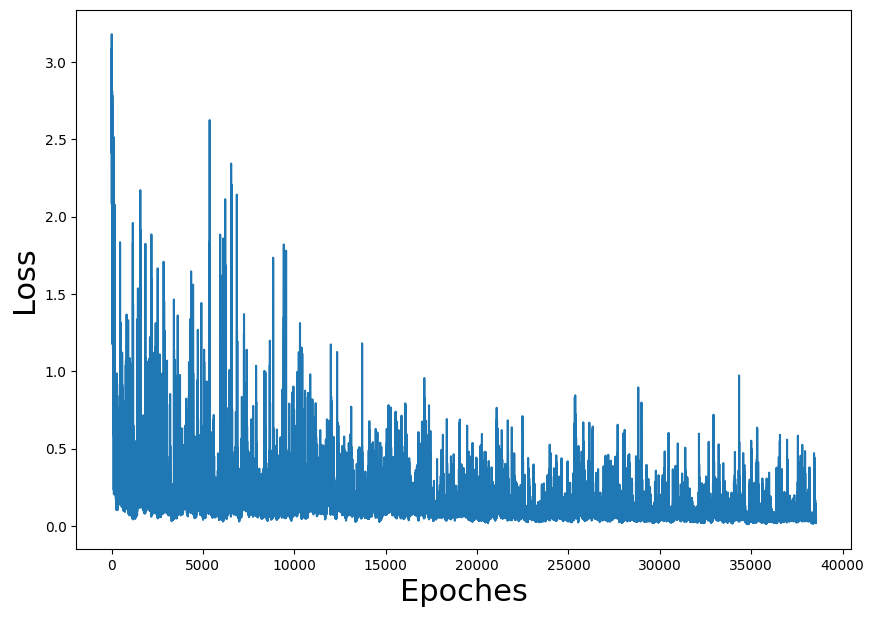

In [18]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epoches",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [19]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break

    win = True if status == 2 else False
    return win

In [20]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model,mode='random',display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 885
Win percentage: 88.5%


In [21]:
test_model(model,mode='random')

Initial State:
[['P' ' ' ' ' '-']
 [' ' ' ' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: r
[[' ' 'P' ' ' '-']
 [' ' ' ' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[[' ' 'P' ' ' '-']
 [' ' ' ' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[[' ' 'P' ' ' '-']
 [' ' ' ' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: u
[[' ' 'P' ' ' '-']
 [' ' ' ' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: u
[[' ' 'P' ' ' '-']
 [' ' ' ' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[[' ' 'P' ' ' '-']
 [' ' ' ' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: d
[[' ' ' ' ' ' '-']
 [' ' 'P' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 7; Taking action: l
[[' ' ' ' ' ' '-']
 ['P' ' ' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 8; Taking action: r
[[' ' ' ' ' ' '-']
 [' ' 'P' '+' ' ']
 [

True